In [28]:
from pathlib import Path
import pandas as pd
import numpy as np
import nibabel as nb
import SUITPy as suit
import matplotlib.pyplot as plt
import seaborn as sb
import Functional_Fusion.atlas_map as am
from Functional_Fusion.dataset import *
import Functional_Fusion.matrix as matrix
import sys

base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'

This notebook checks the quality of different dataset using two metrics
a) Within-subject reliability: Pattern Correlation between each partition and the mean of the rest. Here we do mostly split-half correlation 
b) Between-subejct correlation: Pattern correlation between the average pattern for a single subject and the average across all subjects. This will identify outliers  

### Check MDTB dataset

In [2]:
mdtb_dataset = DataSetMDTB(base_dir + '/MDTB')
data_mdtb1,info_mdtb1 = mdtb_dataset.get_data('SUIT3','ses-s1','CondHalf')

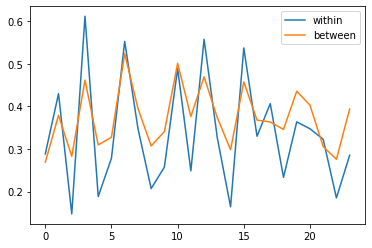

In [3]:
r1 = reliability_within_subj(data_mdtb1,part_vec=info_mdtb1.half,cond_vec=info_mdtb1.cond_name)
r2 = reliability_between_subj(data_mdtb1,cond_vec=info_mdtb1.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

In [5]:
data_mdtb2,info_mdtb2 = mdtb_dataset.get_data('SUIT3','ses-s2','CondHalf')

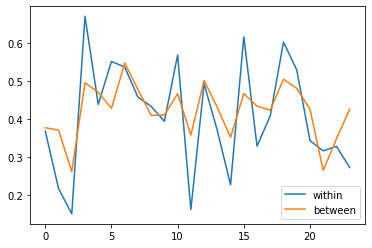

In [6]:
r1 = reliability_within_subj(data_mdtb2,part_vec=info_mdtb2.half,cond_vec=info_mdtb2.cond_name)
r2 = reliability_between_subj(data_mdtb2,cond_vec=info_mdtb2.cond_name)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Pontine data set 

In [7]:
mdtb_dataset = DataSetMDTB(base_dir + '/Pontine')
data_pt,info_pt = mdtb_dataset.get_data('SUIT3','ses-01','TaskHalf')

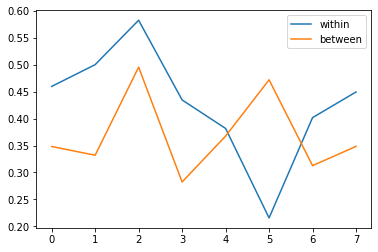

In [8]:
r1 = reliability_within_subj(data_pt,part_vec=info_pt.half,
            cond_vec=info_pt.task_num)
r2 = reliability_between_subj(data_pt,cond_vec=info_pt.task_num)
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['within','between'])

### Nishimoto data set

In [10]:
nn_dataset = DataSetNishi(base_dir + '/Nishimoto')
# Specify the fields you want to have / check 
fiel = ['task_name','reg_id','half']
data_nn1,info_nn1 = nn_dataset.get_data('SUIT3','ses-01',
                                        'CondHalf',fields=fiel)
data_nn2,info_nn2 = nn_dataset.get_data('SUIT3','ses-02',
                                        'CondHalf',fields=fiel)


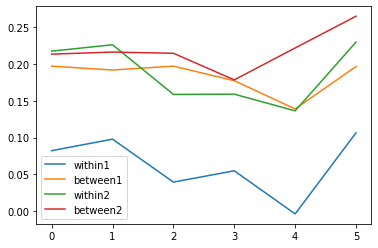

In [11]:
r1w = reliability_within_subj(data_nn1,part_vec=info_nn1.half,cond_vec=info_nn1.reg_id)
r1b = reliability_between_subj(data_nn1,cond_vec=info_nn1.reg_id)
r2w = reliability_within_subj(data_nn2,part_vec=info_nn2.half,cond_vec=info_nn2.reg_id)
r2b = reliability_between_subj(data_nn2,cond_vec=info_nn2.reg_id)
R = np.c_[r1w.mean(axis=1),r1b,r2w.mean(axis=1),r2b]
plt.plot(R)
plt.legend(['within1','between1','within2','between2'])

Interestingly, Data set 1 (training data) has very low within-person reliability. Why is this exactly?

### IBC data set
Do a session-wise test

In [16]:
dataset = DataSetIBC(base_dir + '/IBC')
# Specify the fields you want to have / check 
T = dataset.get_participants()
num_sess = len(dataset.sessions)
RW = np.empty((T.shape[0],num_sess))
RB = np.empty((T.shape[0],num_sess))
Missing = np.empty((T.shape[0],num_sess))

for i,ses in enumerate(dataset.sessions):
    data,info = dataset.get_data('MNISymC3',ses,'CondHalf')
    m = np.isnan(data).sum(axis=1)
    Missing[:,i] = (m>0).sum(axis=1)
    rw = reliability_within_subj(data,part_vec=info.half,cond_vec=info.reg_num)
    RW[:,i] = rw.mean(axis=1)
    RB[:,i] = reliability_between_subj(data,cond_vec=info.reg_num)



In [4]:
Missing

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 4., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 5., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

(12, 14)


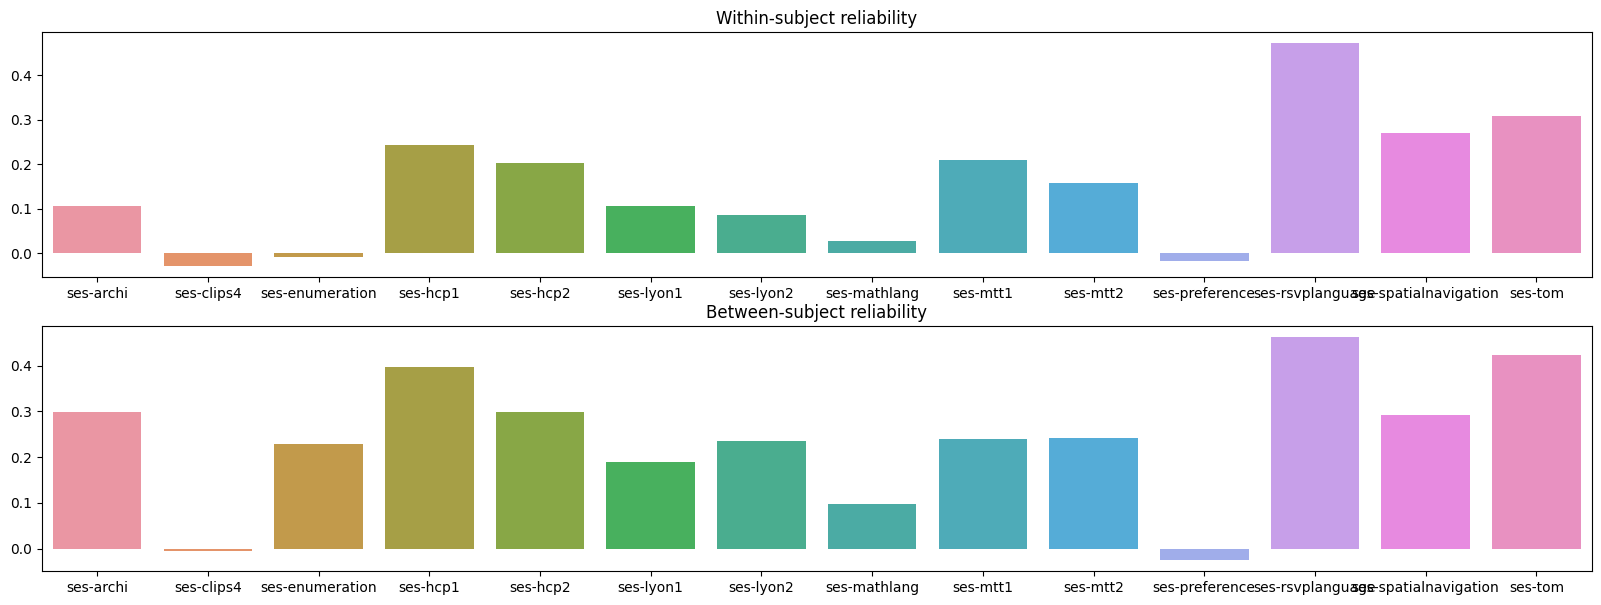

In [10]:
plt.figure(figsize=(20,7))
plt.subplot(2,1,1)
plt.title('Within-subject reliability')
sb.barplot(x=dataset.sessions,y=RW.mean(axis=0))
plt.subplot(2,1,2)
plt.title('Between-subject reliability')
sb.barplot(x=dataset.sessions,y=RB.mean(axis=0))
print(RB.shape)

In [24]:
dataset.sessions

['ses-archi',
 'ses-clips4',
 'ses-enumeration',
 'ses-hcp1',
 'ses-hcp2',
 'ses-lyon1',
 'ses-lyon2',
 'ses-mathlang',
 'ses-mtt1',
 'ses-mtt2',
 'ses-preference',
 'ses-rsvplanguage',
 'ses-spatialnavigation',
 'ses-tom']

<AxesSubplot: xlabel='Participant', ylabel='Between-subject reliability'>

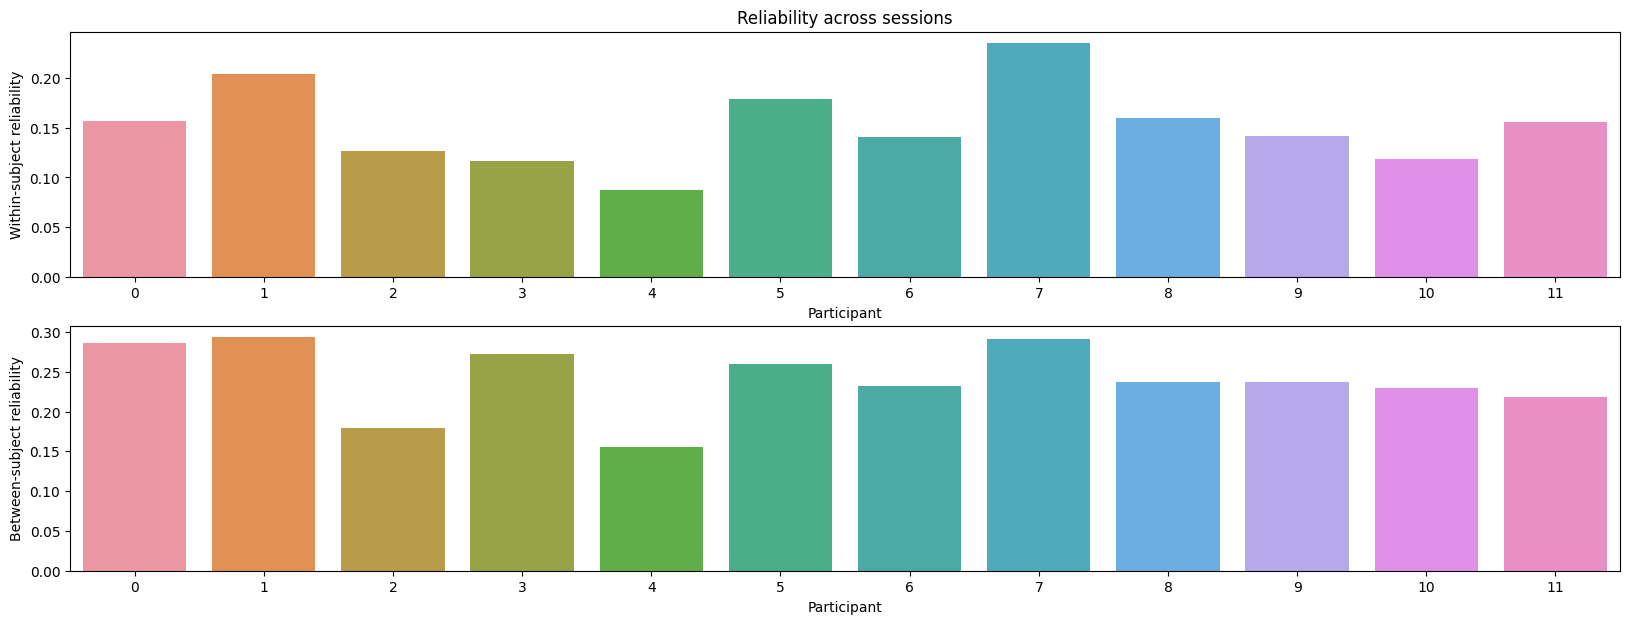

In [14]:
# Per Subject 
plt.figure(figsize=(20,7))
plt.subplot(2,1,1)
plt.title("Reliability across sessions")
plt.ylabel('Within-subject reliability')
plt.xlabel('Participant')
sb.barplot(x=np.arange(RW.shape[0]),y=RW.mean(axis=1))
plt.subplot(2,1,2)
plt.ylabel('Between-subject reliability')
plt.xlabel('Participant')
sb.barplot(x=np.arange(RB.shape[0]),y=RB.mean(axis=1))

2. Do a check of the entire dataset after concatinating all sessions

In [20]:
dataset = DataSetIBC(base_dir + '/IBC')
# Specify the fields you want to have / check 
T = dataset.get_participants()
num_sess = len(dataset.sessions)

data,info,ds = get_dataset(base_dir,'IBC',atlas='MNISymC3',type='CondHalf')


In [17]:
# Number of missing voxels per subject 
missing = np.isnan(data.sum(axis=1))
missing.sum(axis=1)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(12, 592)

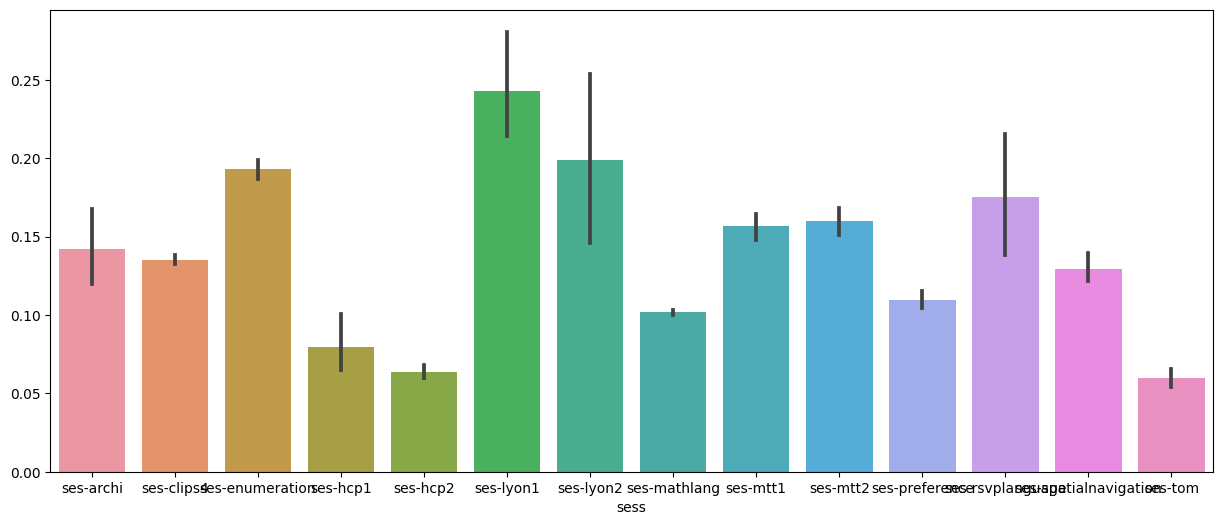

In [22]:
# variance of voxel patterns across sessions 
# This checks whether the activity estimates are approximately 
# equally scaled
# Variance over voxels, averaged across subject
STD = np.nanstd(data,axis=2).mean(axis=0)
plt.figure(figsize=(15,6))
sb.barplot(x=info.sess,y=STD)


### Check HCP dataset

## Connectivity Type: Icosahedron (type=IcoRun)

In [20]:
hcp_dataset = DataSetHcpResting(base_dir + '/HCP')
data_hcp1,info_hcp1 = hcp_dataset.get_data( 'MNISymC3', ses_id = 'ses-s1', type='IcoRun')
data_hcp2,info_hcp2 = hcp_dataset.get_data( 'MNISymC3', ses_id = 'ses-s2', type='IcoRun')

In [ ]:
r1 = reliability_within_subj(
    data_hcp1, part_vec=info_hcp1.run, cond_vec=info_hcp1.region_name)
r2 = reliability_between_subj(data_hcp1, cond_vec=info_hcp1.region_name)

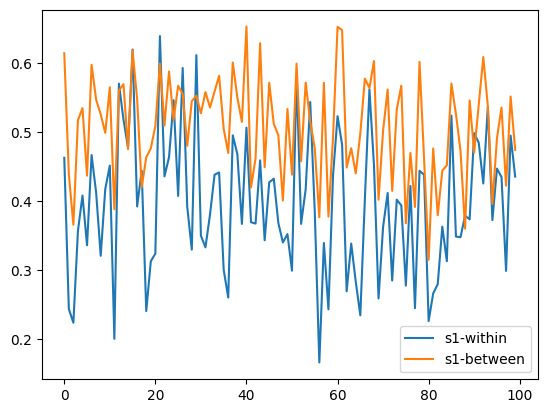

In [23]:
plt.plot(r1.mean(axis=1))
plt.plot(r2)

plt.legend(['s1-within','s1-between'])

In [21]:
r1s2 = reliability_within_subj(
    data_hcp2, part_vec=info_hcp2.run, cond_vec=info_hcp2.region_name)
r2s2 = reliability_between_subj(data_hcp2, cond_vec=info_hcp2.region_name)


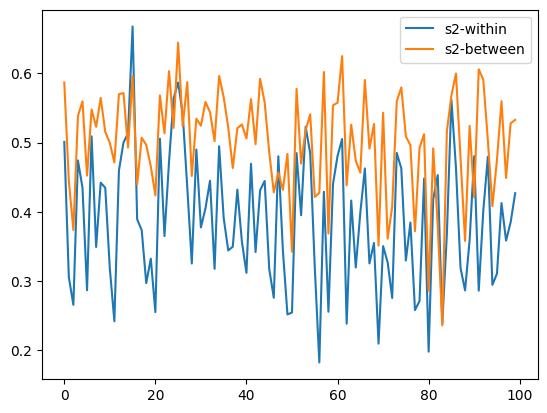

In [24]:

plt.plot(r1s2.mean(axis=1))
plt.plot(r2s2)
plt.legend(['s2-within','s2-between'])

## Connectivity Type: Network (type=NetRun)

In [23]:
hcpnets_dataset = DataSetHcpResting(base_dir + '/HCP')
data_hcpnets1, info_hcpnets1 = hcpnets_dataset.get_data(
    'MNISymC3', ses_id='ses-s1', type='NetRun')

In [10]:
r1 = reliability_within_subj(
    data_hcpnets1, part_vec=info_hcpnets1.run, cond_vec=info_hcpnets1.region_name)
r2 = reliability_between_subj(
    data_hcpnets1, cond_vec=info_hcpnets1.region_name)


/Users/callithrix/Python/Functional_Fusion/dataset.py:158: RuntimeWarning: invalid value encountered in double_scalars
  r[s,pn] = nansum(X1*X2)/sqrt(nansum(X1*X1)*nansum(X2*X2))
/Users/callithrix/Python/Functional_Fusion/dataset.py:195: RuntimeWarning: invalid value encountered in double_scalars
  r[i] = nansum(X1*X2)/sqrt(nansum(X1*X1)*nansum(X2*X2))


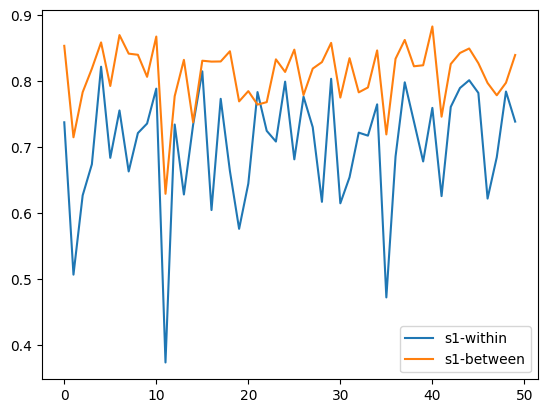

In [11]:
plt.plot(r1.mean(axis=1))
plt.plot(r2)
plt.legend(['s1-within','s1-between'])

/Users/callithrix/Python/Functional_Fusion/dataset.py:158: RuntimeWarning: invalid value encountered in double_scalars
  r[s,pn] = nansum(X1*X2)/sqrt(nansum(X1*X1)*nansum(X2*X2))
/Users/callithrix/Python/Functional_Fusion/dataset.py:195: RuntimeWarning: invalid value encountered in double_scalars
  r[i] = nansum(X1*X2)/sqrt(nansum(X1*X1)*nansum(X2*X2))


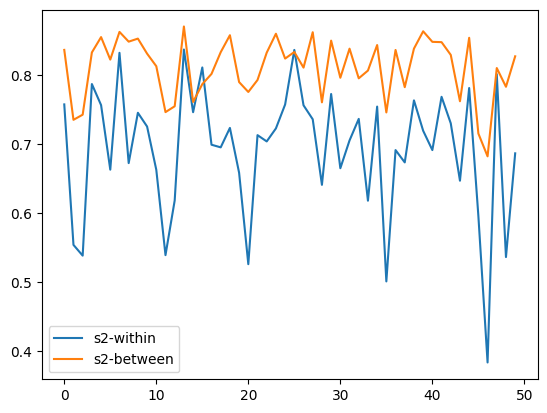

In [29]:
data_hcpnet2, info_hcpnet2 = hcpnets_dataset.get_data(
    'MNISymC3', ses_id='ses-s2', type='NetRun')
r1s2 = reliability_within_subj(
    data_hcpnet2, part_vec=info_hcpnet2.run, cond_vec=info_hcpnet2.region_name)
r2s2 = reliability_between_subj(data_hcpnet2, cond_vec=info_hcpnet2.region_name)
plt.plot(r1s2.mean(axis=1))
plt.plot(r2s2)
plt.legend(['s2-within','s2-between'])